In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


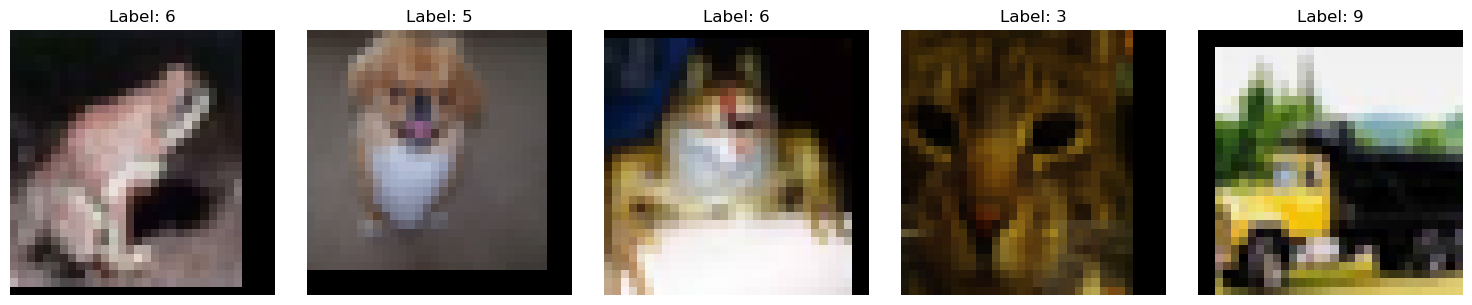

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [10]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [11]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [12]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.01)

In [13]:
print(device)

cuda


In [14]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:52<00:00,  6.73it/s]


Epoch 1 => Train Loss: 1.4343, Acc: 0.4713 | Val Loss: 1.2166, Acc: 0.5752


Epoch 2/100: 100%|██████████| 352/352 [00:50<00:00,  6.93it/s]


Epoch 2 => Train Loss: 0.9603, Acc: 0.6580 | Val Loss: 0.9770, Acc: 0.6716


Epoch 3/100: 100%|██████████| 352/352 [00:51<00:00,  6.83it/s]


Epoch 3 => Train Loss: 0.7424, Acc: 0.7408 | Val Loss: 0.7090, Acc: 0.7582


Epoch 4/100: 100%|██████████| 352/352 [00:51<00:00,  6.84it/s]


Epoch 4 => Train Loss: 0.6052, Acc: 0.7899 | Val Loss: 0.6122, Acc: 0.7918


Epoch 5/100: 100%|██████████| 352/352 [00:50<00:00,  6.95it/s]


Epoch 5 => Train Loss: 0.5197, Acc: 0.8220 | Val Loss: 0.5950, Acc: 0.8024


Epoch 6/100: 100%|██████████| 352/352 [00:50<00:00,  6.92it/s]


Epoch 6 => Train Loss: 0.4652, Acc: 0.8386 | Val Loss: 0.5026, Acc: 0.8350


Epoch 7/100: 100%|██████████| 352/352 [00:51<00:00,  6.88it/s]


Epoch 7 => Train Loss: 0.4169, Acc: 0.8568 | Val Loss: 0.4741, Acc: 0.8424


Epoch 8/100: 100%|██████████| 352/352 [00:50<00:00,  6.91it/s]


Epoch 8 => Train Loss: 0.3781, Acc: 0.8682 | Val Loss: 0.4062, Acc: 0.8628


Epoch 9/100: 100%|██████████| 352/352 [00:51<00:00,  6.86it/s]


Epoch 9 => Train Loss: 0.3465, Acc: 0.8799 | Val Loss: 0.4225, Acc: 0.8586


Epoch 10/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 10 => Train Loss: 0.3145, Acc: 0.8917 | Val Loss: 0.4140, Acc: 0.8654


Epoch 11/100: 100%|██████████| 352/352 [00:39<00:00,  8.89it/s]


Epoch 11 => Train Loss: 0.2989, Acc: 0.8964 | Val Loss: 0.4228, Acc: 0.8610


Epoch 12/100: 100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Epoch 12 => Train Loss: 0.2739, Acc: 0.9055 | Val Loss: 0.3958, Acc: 0.8702


Epoch 13/100: 100%|██████████| 352/352 [00:28<00:00, 12.15it/s]


Epoch 13 => Train Loss: 0.2498, Acc: 0.9132 | Val Loss: 0.4018, Acc: 0.8706


Epoch 14/100: 100%|██████████| 352/352 [00:28<00:00, 12.16it/s]


Epoch 14 => Train Loss: 0.2321, Acc: 0.9190 | Val Loss: 0.4007, Acc: 0.8760


Epoch 15/100: 100%|██████████| 352/352 [00:28<00:00, 12.15it/s]


Epoch 15 => Train Loss: 0.2113, Acc: 0.9273 | Val Loss: 0.3979, Acc: 0.8842


Epoch 16/100: 100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Epoch 16 => Train Loss: 0.2026, Acc: 0.9274 | Val Loss: 0.4024, Acc: 0.8830


Epoch 17/100: 100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Epoch 17 => Train Loss: 0.1833, Acc: 0.9364 | Val Loss: 0.3698, Acc: 0.8892


Epoch 18/100: 100%|██████████| 352/352 [00:29<00:00, 12.12it/s]


Epoch 18 => Train Loss: 0.1723, Acc: 0.9391 | Val Loss: 0.3538, Acc: 0.8968


Epoch 19/100: 100%|██████████| 352/352 [00:29<00:00, 12.11it/s]


Epoch 19 => Train Loss: 0.1649, Acc: 0.9421 | Val Loss: 0.4109, Acc: 0.8824


Epoch 20/100: 100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Epoch 20 => Train Loss: 0.1535, Acc: 0.9466 | Val Loss: 0.4622, Acc: 0.8710


Epoch 21/100: 100%|██████████| 352/352 [00:28<00:00, 12.18it/s]


Epoch 21 => Train Loss: 0.1420, Acc: 0.9501 | Val Loss: 0.3516, Acc: 0.8994


Epoch 22/100: 100%|██████████| 352/352 [00:28<00:00, 12.14it/s]


Epoch 22 => Train Loss: 0.1372, Acc: 0.9514 | Val Loss: 0.3798, Acc: 0.8970


Epoch 23/100: 100%|██████████| 352/352 [00:29<00:00, 12.11it/s]


Epoch 23 => Train Loss: 0.1221, Acc: 0.9562 | Val Loss: 0.3610, Acc: 0.8986


Epoch 24/100: 100%|██████████| 352/352 [00:29<00:00, 12.12it/s]


Epoch 24 => Train Loss: 0.1187, Acc: 0.9579 | Val Loss: 0.3801, Acc: 0.8936


Epoch 25/100: 100%|██████████| 352/352 [00:29<00:00, 12.13it/s]


Epoch 25 => Train Loss: 0.1098, Acc: 0.9607 | Val Loss: 0.4064, Acc: 0.8906


Epoch 26/100: 100%|██████████| 352/352 [00:29<00:00, 12.14it/s]


Epoch 26 => Train Loss: 0.1050, Acc: 0.9626 | Val Loss: 0.3392, Acc: 0.9042


Epoch 27/100: 100%|██████████| 352/352 [00:29<00:00, 12.12it/s]


Epoch 27 => Train Loss: 0.1038, Acc: 0.9636 | Val Loss: 0.4547, Acc: 0.8940


Epoch 28/100: 100%|██████████| 352/352 [00:52<00:00,  6.66it/s]


Epoch 28 => Train Loss: 0.0942, Acc: 0.9666 | Val Loss: 0.3880, Acc: 0.9016


Epoch 29/100: 100%|██████████| 352/352 [00:40<00:00,  8.63it/s]


Epoch 29 => Train Loss: 0.0896, Acc: 0.9685 | Val Loss: 0.3662, Acc: 0.9044


Epoch 30/100: 100%|██████████| 352/352 [00:28<00:00, 12.15it/s]


Epoch 30 => Train Loss: 0.0909, Acc: 0.9679 | Val Loss: 0.4178, Acc: 0.8952


Epoch 31/100: 100%|██████████| 352/352 [00:29<00:00, 12.11it/s]


Epoch 31 => Train Loss: 0.0907, Acc: 0.9690 | Val Loss: 0.4246, Acc: 0.8952


Epoch 32/100: 100%|██████████| 352/352 [00:29<00:00, 12.13it/s]


Epoch 32 => Train Loss: 0.0778, Acc: 0.9725 | Val Loss: 0.4145, Acc: 0.8994


Epoch 33/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 33 => Train Loss: 0.0706, Acc: 0.9750 | Val Loss: 0.3730, Acc: 0.9088


Epoch 34/100: 100%|██████████| 352/352 [00:28<00:00, 12.16it/s]


Epoch 34 => Train Loss: 0.0756, Acc: 0.9733 | Val Loss: 0.3773, Acc: 0.9050


Epoch 35/100: 100%|██████████| 352/352 [00:29<00:00, 12.13it/s]


Epoch 35 => Train Loss: 0.0670, Acc: 0.9760 | Val Loss: 0.3699, Acc: 0.9100


Epoch 36/100: 100%|██████████| 352/352 [00:31<00:00, 11.21it/s]


Epoch 36 => Train Loss: 0.0674, Acc: 0.9761 | Val Loss: 0.3765, Acc: 0.9080


Epoch 37/100: 100%|██████████| 352/352 [00:49<00:00,  7.07it/s]


Epoch 37 => Train Loss: 0.0634, Acc: 0.9774 | Val Loss: 0.4097, Acc: 0.9062


Epoch 38/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 38 => Train Loss: 0.0646, Acc: 0.9776 | Val Loss: 0.3726, Acc: 0.9096


Epoch 39/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 39 => Train Loss: 0.0622, Acc: 0.9781 | Val Loss: 0.3842, Acc: 0.9084


Epoch 40/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 40 => Train Loss: 0.0624, Acc: 0.9779 | Val Loss: 0.6063, Acc: 0.8748


Epoch 41/100: 100%|██████████| 352/352 [00:28<00:00, 12.20it/s]


Epoch 41 => Train Loss: 0.0611, Acc: 0.9788 | Val Loss: 0.4200, Acc: 0.9022


Epoch 42/100: 100%|██████████| 352/352 [00:28<00:00, 12.18it/s]


Epoch 42 => Train Loss: 0.0555, Acc: 0.9803 | Val Loss: 0.4125, Acc: 0.9034


Epoch 43/100: 100%|██████████| 352/352 [00:28<00:00, 12.19it/s]


Epoch 43 => Train Loss: 0.0505, Acc: 0.9821 | Val Loss: 0.4504, Acc: 0.9038


Epoch 44/100: 100%|██████████| 352/352 [00:28<00:00, 12.15it/s]


Epoch 44 => Train Loss: 0.0545, Acc: 0.9811 | Val Loss: 0.4064, Acc: 0.9112


Epoch 45/100: 100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Epoch 45 => Train Loss: 0.0527, Acc: 0.9815 | Val Loss: 0.4259, Acc: 0.9058


Epoch 46/100: 100%|██████████| 352/352 [00:28<00:00, 12.14it/s]


Epoch 46 => Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.3905, Acc: 0.9140


Epoch 47/100: 100%|██████████| 352/352 [00:28<00:00, 12.18it/s]


Epoch 47 => Train Loss: 0.0486, Acc: 0.9829 | Val Loss: 0.4021, Acc: 0.9098


Epoch 48/100: 100%|██████████| 352/352 [00:29<00:00, 12.12it/s]


Epoch 48 => Train Loss: 0.0476, Acc: 0.9833 | Val Loss: 0.4488, Acc: 0.9066


Epoch 49/100: 100%|██████████| 352/352 [00:28<00:00, 12.17it/s]


Epoch 49 => Train Loss: 0.0507, Acc: 0.9825 | Val Loss: 0.4229, Acc: 0.9096


Epoch 50/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 50 => Train Loss: 0.0436, Acc: 0.9850 | Val Loss: 0.4366, Acc: 0.9060


Epoch 51/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 51 => Train Loss: 0.0481, Acc: 0.9831 | Val Loss: 0.4314, Acc: 0.9094


Epoch 52/100: 100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Epoch 52 => Train Loss: 0.0477, Acc: 0.9826 | Val Loss: 0.4193, Acc: 0.9142


Epoch 53/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 53 => Train Loss: 0.0395, Acc: 0.9865 | Val Loss: 0.4410, Acc: 0.9096


Epoch 54/100: 100%|██████████| 352/352 [00:30<00:00, 11.70it/s]


Epoch 54 => Train Loss: 0.0420, Acc: 0.9855 | Val Loss: 0.4408, Acc: 0.9086


Epoch 55/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 55 => Train Loss: 0.0411, Acc: 0.9857 | Val Loss: 0.4796, Acc: 0.9040


Epoch 56/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 56 => Train Loss: 0.0440, Acc: 0.9848 | Val Loss: 0.4360, Acc: 0.9112


Epoch 57/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 57 => Train Loss: 0.0408, Acc: 0.9858 | Val Loss: 0.4626, Acc: 0.9044


Epoch 58/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 58 => Train Loss: 0.0363, Acc: 0.9873 | Val Loss: 0.4229, Acc: 0.9086


Epoch 59/100: 100%|██████████| 352/352 [00:29<00:00, 12.07it/s]


Epoch 59 => Train Loss: 0.0422, Acc: 0.9853 | Val Loss: 0.4943, Acc: 0.9008


Epoch 60/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 60 => Train Loss: 0.0405, Acc: 0.9859 | Val Loss: 0.4525, Acc: 0.9102


Epoch 61/100: 100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Epoch 61 => Train Loss: 0.0384, Acc: 0.9863 | Val Loss: 0.4241, Acc: 0.9092


Epoch 62/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 62 => Train Loss: 0.0375, Acc: 0.9865 | Val Loss: 0.3951, Acc: 0.9140


Epoch 63/100: 100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Epoch 63 => Train Loss: 0.0385, Acc: 0.9865 | Val Loss: 0.4265, Acc: 0.9140


Epoch 64/100: 100%|██████████| 352/352 [00:29<00:00, 11.74it/s]


Epoch 64 => Train Loss: 0.0346, Acc: 0.9881 | Val Loss: 0.4554, Acc: 0.9132


Epoch 65/100: 100%|██████████| 352/352 [00:29<00:00, 12.08it/s]


Epoch 65 => Train Loss: 0.0349, Acc: 0.9882 | Val Loss: 0.4132, Acc: 0.9164


Epoch 66/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 66 => Train Loss: 0.0351, Acc: 0.9873 | Val Loss: 0.4138, Acc: 0.9140


Epoch 67/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 67 => Train Loss: 0.0334, Acc: 0.9882 | Val Loss: 0.4500, Acc: 0.9128


Epoch 68/100: 100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Epoch 68 => Train Loss: 0.0319, Acc: 0.9889 | Val Loss: 0.4349, Acc: 0.9174


Epoch 69/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 69 => Train Loss: 0.0331, Acc: 0.9880 | Val Loss: 0.4996, Acc: 0.9056


Epoch 70/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 70 => Train Loss: 0.0363, Acc: 0.9875 | Val Loss: 0.4495, Acc: 0.9120


Epoch 71/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 71 => Train Loss: 0.0311, Acc: 0.9889 | Val Loss: 0.4189, Acc: 0.9168


Epoch 72/100: 100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Epoch 72 => Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 0.4415, Acc: 0.9144


Epoch 73/100: 100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Epoch 73 => Train Loss: 0.0317, Acc: 0.9890 | Val Loss: 0.4670, Acc: 0.9108


Epoch 74/100: 100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Epoch 74 => Train Loss: 0.0284, Acc: 0.9901 | Val Loss: 0.4318, Acc: 0.9198


Epoch 75/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 75 => Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.4774, Acc: 0.9108


Epoch 76/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 76 => Train Loss: 0.0351, Acc: 0.9876 | Val Loss: 0.4332, Acc: 0.9136


Epoch 77/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 77 => Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.4098, Acc: 0.9150


Epoch 78/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 78 => Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.4692, Acc: 0.9144


Epoch 79/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 79 => Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.4496, Acc: 0.9142


Epoch 80/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 80 => Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.4396, Acc: 0.9168


Epoch 81/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 81 => Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.4514, Acc: 0.9136


Epoch 82/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 82 => Train Loss: 0.0299, Acc: 0.9894 | Val Loss: 0.4389, Acc: 0.9178


Epoch 83/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 83 => Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 0.4323, Acc: 0.9170


Epoch 84/100: 100%|██████████| 352/352 [00:29<00:00, 12.03it/s]


Epoch 84 => Train Loss: 0.0293, Acc: 0.9899 | Val Loss: 0.4452, Acc: 0.9146


Epoch 85/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 85 => Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.4289, Acc: 0.9178


Epoch 86/100: 100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Epoch 86 => Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.4670, Acc: 0.9116


Epoch 87/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 87 => Train Loss: 0.0318, Acc: 0.9891 | Val Loss: 0.4688, Acc: 0.9108


Epoch 88/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 88 => Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.4484, Acc: 0.9168


Epoch 89/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 89 => Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.4792, Acc: 0.9070


Epoch 90/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 90 => Train Loss: 0.0279, Acc: 0.9901 | Val Loss: 0.4405, Acc: 0.9212


Epoch 91/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 91 => Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.4031, Acc: 0.9240


Epoch 92/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 92 => Train Loss: 0.0272, Acc: 0.9904 | Val Loss: 0.4473, Acc: 0.9180


Epoch 93/100: 100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Epoch 93 => Train Loss: 0.0255, Acc: 0.9909 | Val Loss: 0.4578, Acc: 0.9112


Epoch 94/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 94 => Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.4417, Acc: 0.9178


Epoch 95/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 95 => Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.4935, Acc: 0.9084


Epoch 96/100: 100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Epoch 96 => Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.4294, Acc: 0.9184


Epoch 97/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 97 => Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.4640, Acc: 0.9094


Epoch 98/100: 100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Epoch 98 => Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.4469, Acc: 0.9162


Epoch 99/100: 100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Epoch 99 => Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.4458, Acc: 0.9166


Epoch 100/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 100 => Train Loss: 0.0225, Acc: 0.9922 | Val Loss: 0.4320, Acc: 0.9172


In [15]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adamW_weight_decay2.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

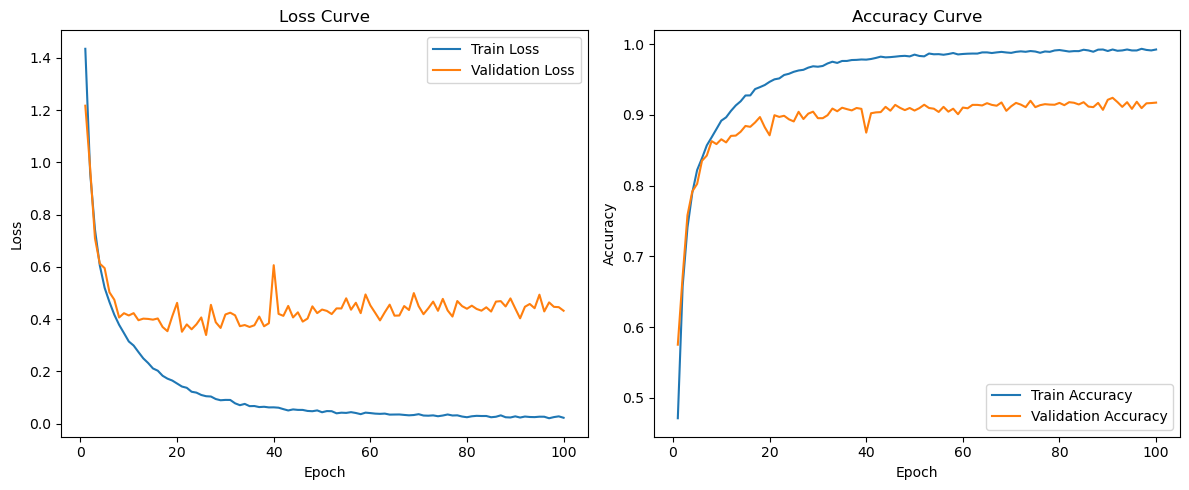

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [17]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.99%


In [18]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model_adamW_weight2.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.56%
